([1.4790482779731475, 0.44463939623560345, 0.7982635907763361], '9s', 279)


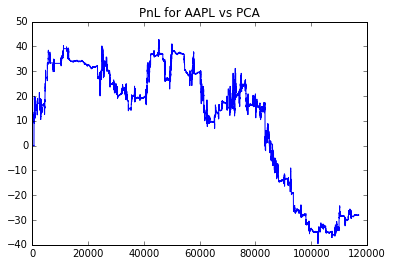

Number of trades: 72
Dollar per trade: -3.88402777778e-05


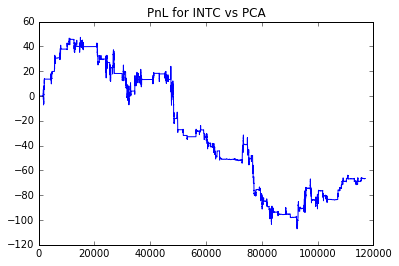

Number of trades: 83
Dollar per trade: -8.0186746988e-05


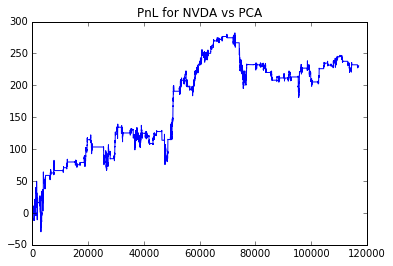

Number of trades: 83
Dollar per trade: 0.00027784939759


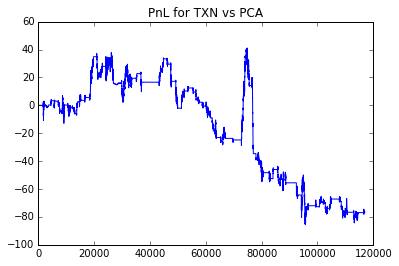

Number of trades: 94
Dollar per trade: -8.15106382979e-05


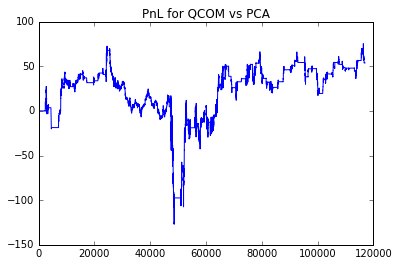

Number of trades: 72
Dollar per trade: 7.46736111111e-05


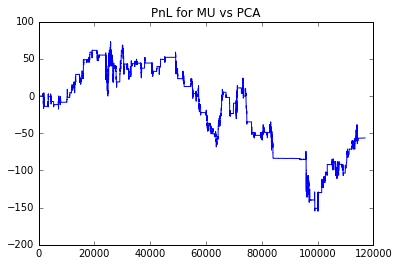

Number of trades: 89
Dollar per trade: -6.34213483146e-05
-5.06890939325e-07
CPU times: user 2 s, sys: 4.85 s, total: 6.85 s
Wall time: 41min 55s


In [33]:
%%time
import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from scipy import integrate 
from scipy import optimize
import random


class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time, pnl, buy_dollars, sell_dollars, 
                 threshold, interval, training_size, trades, pca_weights, shares, ticker1):
        self.session = session
        self.date = date
        self.ticker = ticker1
        self.start_time = start_time
        self.end_time = end_time
        self.halt_trading = string_to_micro('5m') # close position 5 minutes before trading ends
        self.interval = string_to_micro(interval)
        self.interval_pnl = string_to_micro('1s')
        self.state = 'NULL'
        self.pca_tickers = tickers
        self.pca_weights = pca_weights
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = [0 for i in range(len(self.pca_tickers))]
        self.buy_size = 10000 * 10**6
        
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_dollars = buy_dollars
        self.sell_dollars = sell_dollars
        self.shares = shares
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.trades = trades
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.dt = 1
        self.long_open = threshold[0]
        self.long_close = threshold[1]
        self.short_open = threshold[0]
        self.short_close = threshold[2]
        self.training_size = training_size
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        for tick in self.pca_tickers:
            self.session.subscribe_ticker_all_feeds(tick)
            
        # list to store pnl every time we update it
        self.pnl = pnl
        
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        self.pca = {}
        self.pca['Portfolio'] = []
        
        self.results[self.ticker] = []
        self.results['return {}'.format(self.ticker)] = []
        
        for tick in self.pca_tickers:
            self.pca['Midmarket {}'.format(tick)] = []
            self.pca['Return {}'.format(tick)] = []
    
    
    def start_callback(self, time):
        for tick in self.pca_tickers:
            self.session.subscribe_event(tick, ORDER_EVENTS, self.event_callback)
            
        self.session.add_timer(time, self.timer_callback_pnl)
        self.session.add_timer(time, self.timer_callback_algo)
        
    
    def event_callback(self, tick, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
        
    def timer_callback_pnl(self, time):   
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
        
        if time < self.end_time:
            self.session.add_timer(time + self.interval_pnl, self.timer_callback_pnl)
            
    
    def timer_callback_algo(self, time):
        # append the midprices
        self.results[self.ticker].append(self.get_midmarket(self.ticker) / 1000000.0)

        for tick in self.pca_tickers:
            self.pca['Midmarket {}'.format(tick)].append(self.get_midmarket(tick) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker)].append(np.float(returns(self.results[self.ticker][-2:])))
            
            temp_return = 0
            for i in range(len(self.pca_tickers)):
                tick = self.pca_tickers[i]
                self.pca['Return {}'.format(tick)].append(np.float(returns(self.pca['Midmarket {}'.format(tick)][-2:])))
                temp_return += self.pca['Return {}'.format(tick)][-1] * self.pca_weights[i]
                
            self.pca['Portfolio'].append(temp_return)
            
        self.results['time'].append(micro_to_time(time))

        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.halt_trading + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker)][-self.training_size:]
            returns2 = self.pca['Portfolio'][-self.training_size:]
            
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            s = sscore(m, sigmaeq)
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.shares[self.ticker]['B'] - self.shares[self.ticker]['S']           
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
            
            # get the best bid and offer
            bid1, ask1 = self.session.get_inside_market(self.ticker)
            if not orders and b > 0 and kappa > 0 and sigma > 0 and time < self.end_time - self.halt_trading:
                if pos == 0:
                    if s < -self.long_open:
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']
                        self.order_size1 = int(self.buy_size / price1)
                        self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        for i in range(len(self.pca_tickers)):
                            ticker = self.pca_tickers[i]
                            bid2, ask2 = self.session.get_inside_market(ticker)
                            price2 = bid2['price']
                            # make the portfolio self financing by making sure we sell for as much as we buy
                            self.order_size2[i] = int(b * self.buy_size * self.pca_weights[i] / price2)
                            self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)

                        self.trades += 1 
                    elif s > self.short_open:
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']
                        self.order_size1 = int(self.buy_size / price1)
                        self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        for i in range(len(self.pca_tickers)):
                            ticker = self.pca_tickers[i]
                            bid2, ask2 = self.session.get_inside_market(ticker)
                            price2 = ask2['price']
                            # make the portfolio self financing by making sure we sell for as much as we buy
                            self.order_size2[i] = int(b * self.buy_size * self.pca_weights[i] / price2)
                            self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)

                        self.trades += 1 
                        
                elif pos < 0 and s < self.short_close:
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']
                    self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    for i in range(len(self.pca_tickers)):
                        ticker = self.pca_tickers[i]
                        bid2, ask2 = self.session.get_inside_market(ticker)
                        price2 = bid2['price']
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
 
                elif pos > 0 and s > -self.long_close:
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']
                    self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    for i in range(len(self.pca_tickers)):
                        ticker = self.pca_tickers[i]
                        bid2, ask2 = self.session.get_inside_market(ticker)
                        price2 = ask2['price']
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
            
        if time >= self.end_time - self.halt_trading and pos != 0:
            if pos < 0:
                self.side1 = BUY
                self.side2 = SELL
                price1 = ask1['price']
                self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                for i in range(len(self.pca_tickers)):
                    ticker = self.pca_tickers[i]
                    bid2, ask2 = self.session.get_inside_market(ticker)
                    price2 = bid2['price']
                    # make the portfolio self financing by making sure we sell for as much as we buy
                    self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
                
            elif pos > 0:
                self.side1 = SELL
                self.side2 = BUY
                price1 = bid1['price']
                self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                for i in range(len(self.pca_tickers)):
                    ticker = self.pca_tickers[i]
                    bid2, ask2 = self.session.get_inside_market(ticker)
                    price2 = ask2['price']
                    # make the portfolio self financing by making sure we sell for as much as we buy
                    self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)    
    
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback_algo)
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                        
                self.shares[ticker][side] += ex['quantity_executed']
                if side == 'B':
                    self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                else:
                    self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                pnl = self.get_pnl()
               
                
    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2.0
    
    
    def get_pnl(self):
        # mark to the midmarket
        pnl = self.sell_dollars - self.buy_dollars
        for ticker in self.pca_tickers:
            mid = self.get_midmarket(ticker)
            pnl += (self.shares[ticker]['B'] - self.shares[ticker]['S']) * mid
        return pnl
    
    
    def end(self):
        plot_graph(self.pnl, self.ticker, 'PCA')
        return (self.pnl, self.buy_dollars, self.sell_dollars, self.trades, self.shares)


def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b


def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return


def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0


def sscore(m, sigmaeq):
    if sigmaeq != 0:
        return -m/sigmaeq
    elif m>0:
        return 10000000
    else:
        return -10000000


def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    return None
    

# generalize the process of simulating the algorithm
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")
dates = ['20170418', '20170419', '20170420', '20170421', '20170424']
        #['20170410', '20170411', '20170412', '20170413', '20170417'] 
         #'20170418', '20170419', '20170420', '20170421', '20170424']

pca_tickers = ['AAPL', 'MSFT', 'GOOGL', 'FB', 'INTC', 'CSCO', 'NVDA', 
               'ADBE', 'TXN', 'AVGO', 'QCOM', 'MU', 'BIDU']
tickers = ['AAPL', 'INTC', 'NVDA', 'TXN', 'QCOM', 'MU']

pca_weights = [0.20616074, 0.29121571, 0.28953237, 0.25233613, 0.31817724,
                 0.28766794, 0.24683757, 0.30186135, 0.31492926, 0.29388122,
                 0.27183746, 0.27004335, 0.23829469]
pca_weights = pca_weights / np.sum(pca_weights)

threshold = [1.4790482779731475, 0.44463939623560345, 0.7982635907763361]
interval = '9s'
training_size = 279
print(threshold, interval, training_size)
avg_dollar_trade = 0

for ticker1 in tickers:   
    pnl = []         
    buy_dollars = 0
    sell_dollars = 0
    trades = 0
    shares = {}
    for tick in pca_tickers:
        shares[tick] = {'B': 0, 'S': 0}
        
    for date in dates:
        sim = Simulator(Ave_Lee)
        (pnl, buy_dollars, sell_dollars, trades, shares) = sim.run(date, pca_tickers, use_om=True, 
                start_time=start_time, end_time=end_time, pnl=pnl, buy_dollars=buy_dollars, 
                sell_dollars=sell_dollars, threshold=threshold, interval=interval, training_size=training_size, 
                trades=trades, pca_weights=pca_weights, shares=shares, ticker1=ticker1)
        
    plot_graph(pnl, ticker1, 'PCA')
    print('Number of trades: ' + str(trades))
    if trades > 0:   
        dollar_trade = pnl[-1] / (10000 * trades)  
        print('Dollar per trade: ' + str(dollar_trade))
        
    avg_dollar_trade += dollar_trade / len(ticker1)
print(avg_dollar_trade)
             

In [32]:
print('Best dollar per trade: ' + str(best_dollar_trade))
print(best_threshold)
print(best_interval)
print(best_size)

Best dollar per trade: -2.23052944509e-05
[1.4790482779731475, 0.44463939623560345, 0.7982635907763361]
9s
279


PCA combined with stochastic control

(1.9, '9s', 279)


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

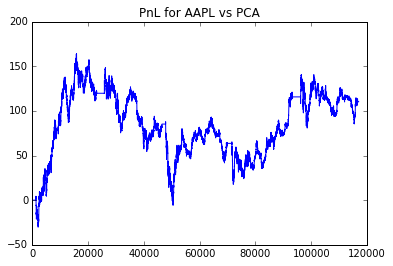

Number of trades: 10
Dollar per trade: 0.0011044


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

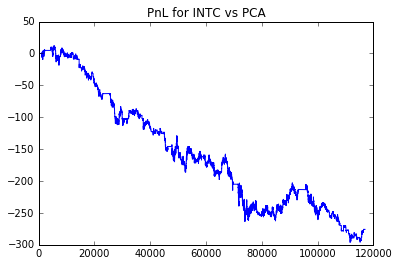

Number of trades: 12
Dollar per trade: -0.00229858333333


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

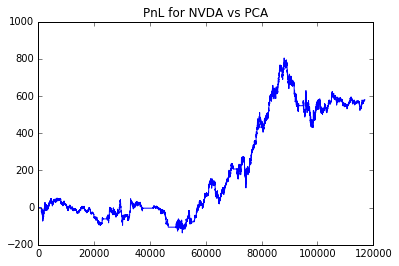

Number of trades: 18
Dollar per trade: 0.00321772222222


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

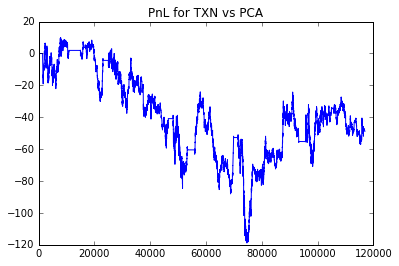

Number of trades: 16
Dollar per trade: -0.000304375


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

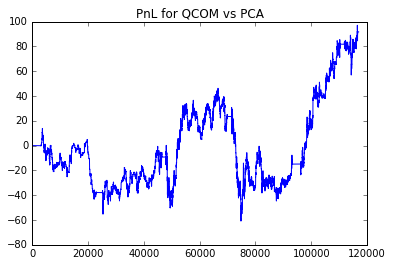

Number of trades: 12
Dollar per trade: 0.000764375


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and

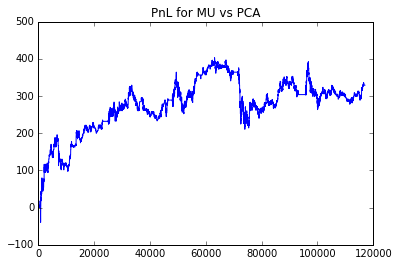

Number of trades: 12
Dollar per trade: 0.00274108333333
0.00087077037037
CPU times: user 1.78 s, sys: 3.26 s, total: 5.04 s
Wall time: 1h 39min 37s


In [39]:
%%time
##The parameters are the same as in the other file, BUT threshold is removed, and instead we have to choose constans rho>0 (urgency parameter) and c
## and c>0 (a measure of the transaction costs). I have incorportared these two parameters to the class constructor and removed thresholds
## rho should be close to 0 (I have tried 0.01 and 0.001) and c as well (I have tried 0.01)

##The only differences with the other file are the block with all the new functions to compute the thresholds, and then in the execution part
#that instead of comparing s with fixed thresholds, we compare the last residual with a threshold that deppends on the OU parameters


import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from scipy import integrate 
from scipy import optimize

class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time, pnl, buy_dollars, sell_dollars,
                 interval, training_size, trades, pca_weights, shares, ticker1, rho, c):
        self.session = session
        self.date = date
        self.ticker = ticker1
        self.start_time = start_time
        self.end_time = end_time
        self.halt_trading = string_to_micro('5m') # close position 5 minutes before trading ends
        self.interval = string_to_micro(interval)
        self.interval_pnl = string_to_micro('1s')
        self.state = 'NULL'
        self.pca_tickers = tickers
        self.pca_weights = pca_weights
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = [0 for i in range(len(self.pca_tickers))]
        self.buy_size = 10000 * 10**6
        
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_dollars = buy_dollars
        self.sell_dollars = sell_dollars
        self.shares = shares
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.trades = trades
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.dt = 1
        self.rho = rho
        self.c = c
        self.training_size = training_size
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        for tick in self.pca_tickers:
            self.session.subscribe_ticker_all_feeds(tick)
            
        # list to store pnl every time we update it
        self.pnl = pnl
        
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        self.pca = {}
        self.pca['Portfolio'] = []
        
        self.results[self.ticker] = []
        self.results['return {}'.format(self.ticker)] = []
        
        for tick in self.pca_tickers:
            self.pca['Midmarket {}'.format(tick)] = []
            self.pca['Return {}'.format(tick)] = []
    
    
    def start_callback(self, time):
        for tick in self.pca_tickers:
            self.session.subscribe_event(tick, ORDER_EVENTS, self.event_callback)
            
        self.session.add_timer(time, self.timer_callback_pnl)
        self.session.add_timer(time, self.timer_callback_algo)
        
    
    def event_callback(self, tick, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
        
    def timer_callback_pnl(self, time):   
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
        
        if time < self.end_time:
            self.session.add_timer(time + self.interval_pnl, self.timer_callback_pnl)
            
    
    def timer_callback_algo(self, time):
        # append the midprices
        self.results[self.ticker].append(self.get_midmarket(self.ticker) / 1000000.0)

        for tick in self.pca_tickers:
            self.pca['Midmarket {}'.format(tick)].append(self.get_midmarket(tick) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker)].append(np.float(returns(self.results[self.ticker][-2:])))
            
            temp_return = 0
            for i in range(len(self.pca_tickers)):
                tick = self.pca_tickers[i]
                self.pca['Return {}'.format(tick)].append(np.float(returns(self.pca['Midmarket {}'.format(tick)][-2:])))
                temp_return += self.pca['Return {}'.format(tick)][-1] * self.pca_weights[i]
                
            self.pca['Portfolio'].append(temp_return)
            
        self.results['time'].append(micro_to_time(time))

        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.halt_trading + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker)][-self.training_size:]
            returns2 = self.pca['Portfolio'][-self.training_size:]
            
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.shares[self.ticker]['B'] - self.shares[self.ticker]['S']           
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
            
            residual = 3 * residuals[-1]
            
            # get the best bid and offer
            bid1, ask1 = self.session.get_inside_market(self.ticker)
            if not orders and b > 0 and kappa > 0 and sigma > 0 and time < self.end_time - self.halt_trading:
                if pos == 0:
                    if residual < long_open(self.rho,kappa,m,sigma, self.c):
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']
                        self.order_size1 = int(self.buy_size / price1)
                        self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        for i in range(len(self.pca_tickers)):
                            ticker = self.pca_tickers[i]
                            bid2, ask2 = self.session.get_inside_market(ticker)
                            price2 = bid2['price']
                            # make the portfolio self financing by making sure we sell for as much as we buy
                            self.order_size2[i] = int(b * self.buy_size * self.pca_weights[i] / price2)
                            self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)

                        self.trades += 1 
                    elif residual > short_open(self.rho,kappa,m,sigma, self.c):
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']
                        self.order_size1 = int(self.buy_size / price1)
                        self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        for i in range(len(self.pca_tickers)):
                            ticker = self.pca_tickers[i]
                            bid2, ask2 = self.session.get_inside_market(ticker)
                            price2 = ask2['price']
                            # make the portfolio self financing by making sure we sell for as much as we buy
                            self.order_size2[i] = int(b * self.buy_size * self.pca_weights[i] / price2)
                            self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)

                        self.trades += 1 
                        
                elif pos < 0 and residual < short_close(self.rho,kappa,m,sigma, self.c):
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']
                    self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    for i in range(len(self.pca_tickers)):
                        ticker = self.pca_tickers[i]
                        bid2, ask2 = self.session.get_inside_market(ticker)
                        price2 = bid2['price']
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
 
                elif pos > 0 and residual > long_close(self.rho, kappa, m, sigma, self.c):
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']
                    self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    for i in range(len(self.pca_tickers)):
                        ticker = self.pca_tickers[i]
                        bid2, ask2 = self.session.get_inside_market(ticker)
                        price2 = ask2['price']
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
            
        if time >= self.end_time - self.halt_trading and pos != 0:
            if pos < 0:
                self.side1 = BUY
                self.side2 = SELL
                price1 = ask1['price']
                self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                for i in range(len(self.pca_tickers)):
                    ticker = self.pca_tickers[i]
                    bid2, ask2 = self.session.get_inside_market(ticker)
                    price2 = bid2['price']
                    # make the portfolio self financing by making sure we sell for as much as we buy
                    self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)
                
            elif pos > 0:
                self.side1 = SELL
                self.side2 = BUY
                price1 = bid1['price']
                self.session.add_order(self.ticker, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                for i in range(len(self.pca_tickers)):
                    ticker = self.pca_tickers[i]
                    bid2, ask2 = self.session.get_inside_market(ticker)
                    price2 = ask2['price']
                    # make the portfolio self financing by making sure we sell for as much as we buy
                    self.session.add_order(ticker, self.side2, self.order_size2[i], price2, exchange=EXCH_INET)    
    
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback_algo)
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                        
                self.shares[ticker][side] += ex['quantity_executed']
                if side == 'B':
                    self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                else:
                    self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                pnl = self.get_pnl()
               
                
    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2.0
    
    
    def get_pnl(self):
        # mark to the midmarket
        pnl = self.sell_dollars - self.buy_dollars
        for ticker in self.pca_tickers:
            mid = self.get_midmarket(ticker)
            pnl += (self.shares[ticker]['B'] - self.shares[ticker]['S']) * mid
        return pnl
    
    
    def end(self):
        return (self.pnl, self.buy_dollars, self.sell_dollars, self.trades, self.shares)


def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b


def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return


def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0


def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    return None


#### Functions to compute thresholds
def fplus(u,rho,epsilon,kappa, theta, sigma):
    #return u**(rho/kappa-1)*np.exp(-np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*u**(rho/kappa-1)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fplus_der(u,rho,epsilon,kappa, theta, sigma):
    #return np.sqrt(2*kappa/sigma**2)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*np.sqrt(2*kappa)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fminus(u,rho,epsilon,kappa, theta, sigma):
    #return u**(rho/kappa-1)*np.exp(np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*u**(rho/kappa-1)*np.exp(np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fminus_der(u,rho,epsilon,kappa, theta, sigma):
    #return -np.sqrt(2*kappa/sigma**2)*u**(rho/kappa)*np.exp(np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return -sigma**(rho/kappa)*np.sqrt(2*kappa)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def Fplus(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fplus,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fminus(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fminus,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fplus_der(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fplus_der,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fminus_der(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fminus_der,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def long_close_function(epsilon,rho, kappa, theta, sigma,c):
    return (epsilon[0] - c)*Fplus_der(epsilon[0],rho, kappa, theta, sigma)-Fplus(epsilon[0],rho, kappa, theta, sigma)


def long_close(rho, kappa, theta, sigma, c): #epsilon^*+
    result = optimize.root(long_close_function,[1], args=(rho, kappa, theta, sigma, c,), method = 'lm')
    if result.success:
        return result.x[0]
    else:
        return (kappa*theta+c*rho)/(rho+kappa)

    
def short_close_function(epsilon,rho, kappa, theta, sigma,c):
    return (epsilon[0] + c)*Fminus_der(epsilon[0],rho, kappa, theta, sigma)-Fminus(epsilon[0],rho, kappa, theta, sigma)


def short_close(rho, kappa, theta, sigma, c): #epsilon^*-
    result = optimize.root(short_close_function,[-1], args=(rho, kappa, theta, sigma, c,), method = 'lm')
    if result.success:
        return result.x[0]
    else:
        return (kappa*theta-c*rho)/(rho+kappa)

    
def Hplus(epsilon,kappa,theta, sigma,rho,c):
    epsilonplus = long_close(rho, kappa, theta, sigma,c)
    if epsilon >= epsilonplus:
        return epsilon - c
    else:
        return (epsilonplus - c)*Fplus(epsilon,rho, kappa, theta, sigma)/Fplus(epsilonplus,rho, kappa, theta, sigma)
    
    
def Hplus_der(epsilon,kappa,theta, sigma,rho,c):
    epsilonplus = long_close(rho, kappa, theta, sigma,c)
    if epsilon >= epsilonplus:
        return 1
    else:
        return (epsilonplus - c)*Fplus_der(epsilon,rho, kappa, theta, sigma)/Fplus(epsilonplus,rho, kappa, theta, sigma)

    
def Hminus(epsilon,kappa,theta, sigma,rho, c):
    epsilonminus = short_close(rho, kappa, theta, sigma,c)
    if epsilon <= epsilonminus:
        return -epsilon - c
    else:
        return -(epsilonminus + c)*Fminus(epsilon,rho, kappa, theta, sigma)/Fminus(epsilonminus,rho, kappa, theta, sigma)
    
    
def Hminus_der(epsilon,kappa,theta, sigma,rho, c):
    epsilonminus = short_close(rho, kappa, theta, sigma,c)
    if epsilon <= epsilonminus:
        return -1
    else:
        return -(epsilonminus + c)*Fminus_der(epsilon,rho, kappa, theta, sigma)/Fminus(epsilonminus,rho, kappa, theta, sigma)

    
def long_short_open_function(epsilon,rho,kappa,theta,sigma, c):
    minusepsilon = epsilon[0]
    plusepsilon = epsilon[1]
    
    numA = Fminus(minusepsilon,rho, kappa, theta, sigma)*(Hplus(plusepsilon,kappa,theta,sigma,rho,c)-plusepsilon-c)-Fminus(plusepsilon,rho, kappa, theta, sigma)*(Hminus(minusepsilon,kappa,theta,sigma,rho,c)+minusepsilon-c)
    denA = Fplus(plusepsilon,rho, kappa, theta, sigma)*Fminus(minusepsilon,rho, kappa, theta, sigma)-Fplus(minusepsilon,rho, kappa, theta, sigma)*Fminus(plusepsilon,rho, kappa, theta, sigma)
    A = numA/denA

    numB = Fplus(minusepsilon,rho, kappa, theta, sigma)*(Hplus(plusepsilon,kappa,theta,sigma,rho,c)-plusepsilon-c)-Fplus(plusepsilon,rho, kappa, theta, sigma)*(Hminus(minusepsilon,kappa,theta,sigma,rho,c)+minusepsilon-c)
    denB = Fminus(plusepsilon,rho, kappa, theta, sigma)*Fplus(minusepsilon,rho, kappa, theta, sigma)-Fminus(minusepsilon,rho, kappa, theta, sigma)*Fplus(plusepsilon,rho, kappa, theta, sigma)
    B = numB/denB
    
    y_0 = A*Fplus_der(plusepsilon,rho, kappa, theta, sigma)+B*Fminus_der(plusepsilon,rho, kappa, theta, sigma)+1-Hplus_der(plusepsilon,kappa,theta, sigma,rho, c)
    y_1 = A*Fplus_der(minusepsilon,rho, kappa, theta, sigma)+B*Fminus_der(minusepsilon,rho, kappa, theta, sigma)-1-Hminus_der(minusepsilon,kappa,theta, sigma,rho, c)
    
    return [y_0,y_1]


def long_short_open(rho,kappa,theta,sigma, c):
    return optimize.root(long_short_open_function,[-0.18,1.5 ], args=(rho, kappa, theta, sigma, c,), method = 'hybr').x


def long_open(rho,kappa,theta,sigma, c):
    return short_close(rho,kappa,theta,sigma, c)


def short_open(rho,kappa,theta,sigma, c):
    return long_close(rho,kappa,theta,sigma, c)



# generalize the process of simulating the algorithm
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")
dates = ['20170508', '20170509', '20170510', '20170511', '20170512']


pca_tickers = ['AAPL', 'MSFT', 'GOOGL', 'FB', 'INTC', 'CSCO', 'NVDA', 
               'ADBE', 'TXN', 'AVGO', 'QCOM', 'MU', 'BIDU']

tickers = ['AAPL', 'INTC', 'NVDA', 'TXN', 'QCOM', 'MU']

pca_weights = [0.20616074, 0.29121571, 0.28953237, 0.25233613, 0.31817724,
                 0.28766794, 0.24683757, 0.30186135, 0.31492926, 0.29388122,
                 0.27183746, 0.27004335, 0.23829469]
pca_weights = pca_weights / np.sum(pca_weights)

rho = 1.9
c = 0
interval = '9s'
training_size = 279
print(rho, interval, training_size)
avg_dollar_trade = 0
pnl_aggregate = {}

for ticker1 in tickers:   
    pnl = []         
    buy_dollars = 0
    sell_dollars = 0
    trades = 0
    shares = {}
    for tick in pca_tickers:
        shares[tick] = {'B': 0, 'S': 0}
        
    for date in dates:
        sim = Simulator(Ave_Lee)
        (pnl, buy_dollars, sell_dollars, trades, shares) = sim.run(date, pca_tickers, use_om=True, 
                start_time=start_time, end_time=end_time, pnl=pnl, buy_dollars=buy_dollars, 
                sell_dollars=sell_dollars, interval=interval, training_size=training_size, 
                trades=trades, pca_weights=pca_weights, shares=shares, ticker1=ticker1, rho=rho, c=c)
        
    plot_graph(pnl, ticker1, 'PCA')
    print('Number of trades: ' + str(trades))
    if trades > 0:   
        dollar_trade = pnl[-1] / (10000 * trades)  
        print('Dollar per trade: ' + str(dollar_trade))        
    pnl_aggregate[ticker1] = pnl
    avg_dollar_trade += dollar_trade / len(tickers)
print(avg_dollar_trade)

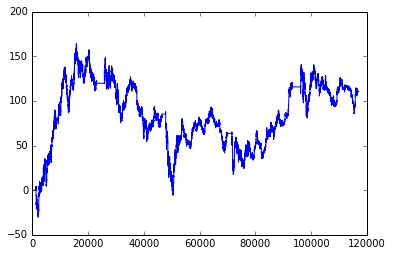

In [43]:
plt.plot(pnl_aggregate['AAPL'])
plt.show()

In [48]:
# all stocks pnl's together
pnl_simul = np.zeros((len(pnl_aggregate['AAPL']),1))
for ticker in pnl_aggregate.keys():
    pnl_simul += np.asarray(pnl_aggregate[ticker]).reshape(-1,1)


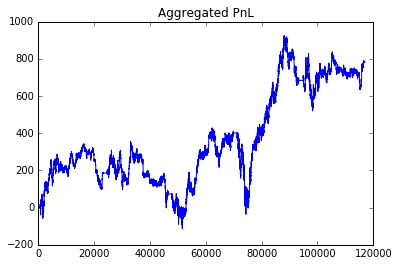

In [50]:
plt.plot(pnl_simul)
plt.title('Aggregated PnL')
plt.show()

In [78]:
pnl_diff = np.diff(pnl_simul[585:], axis=0)

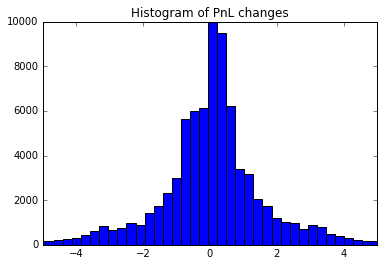

In [86]:
plt.hist(pnl_diff, bins=200)
plt.axis([-5, 5, 0, 10000])
plt.title('Histogram of PnL changes')
plt.show()

In [80]:
np.mean(pnl_diff)

0.0067493708071706526